# 1. Exploratorio de datos

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

data = pd.read_csv('train_set.csv')
print('Cantidad de registros:', data.shape)
data.head()

Cantidad de registros: (700000, 14)


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


### Tipo de datos
* Las fechas actualmente se reconocen como objetos.
* bike_id contiene 17 registros alfanuméricos, como son 15111a y _Test_RFID. Prescindiremos de ellos, pues son una minoría, 8 de ellos duran solo un minuto, y, en su mayoría, emplean la estación 3000. Lejos de enriquecer el modelo, lo entorpecen. Además no es coherente con la definicion del tipo de dato, debe ser de tipo entero.

In [2]:
data.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_lat              float64
start_lon              float64
end_lat                float64
end_lon                float64
bike_id                 object
plan_duration          float64
trip_route_category     object
passholder_type         object
start_station            int64
end_station              int64
dtype: object

Transformaremos el tipo de dato en las fechas a datetime en formato ISO 8601 y eliminaremos las entradas alfanuméricas en bike_id.

In [3]:
alpha = data['bike_id'][pd.to_numeric(data['bike_id'], errors='coerce').isnull()]
print(alpha.count())
data.loc[list(alpha.index)].head()

17


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
47777,150316878,12,11/25/2020 10:02,11/25/2020 10:14,34.000881,-118.468910,33.984341,-118.471550,15111a,30.0,One Way,Monthly Pass,4207,4210
113003,152731884,1,1/27/2021 12:42,1/27/2021 12:43,34.025841,-118.238213,NaN,NaN,_Test_RFID,365.0,Round Trip,Annual Pass,3000,3000
170382,22396682,1,3/17/2017 13:17,3/17/2017 13:18,34.024479,-118.393867,34.024479,-118.393867,Dock Block 2,0.0,Round Trip,Walk-up,3039,3039
227852,152731389,1,1/27/2021 12:18,1/27/2021 12:19,34.025841,-118.238213,NaN,NaN,_Test_RFID,365.0,Round Trip,Annual Pass,3000,3000
260283,118119789,15,2019-03-25 09:03:00,2019-03-25 09:18:00,NaN,NaN,NaN,NaN,Rblock,365.0,Round Trip,Walk-up,3000,3000


In [4]:
data['start_time'] = pd.to_datetime(data['start_time'],infer_datetime_format=True)
data['end_time'] = pd.to_datetime(data['end_time'],infer_datetime_format=True)
data = data.drop(alpha.index)
data['bike_id'] = data['bike_id'].astype('int')
print('Cantidad de registros:', data.shape)
data.dtypes[[2,3,8]] #start, end time y bike_id

Cantidad de registros: (699983, 14)


start_time    datetime64[ns]
end_time      datetime64[ns]
bike_id                int32
dtype: object

## Saturación del servicio:
### La empresa busca contar con la disponibilidad más alta de servicio en el mercado, por lo que se quiere entender cómo se comporta la demanda de servicio en las distintas estaciones y horarios para cada plan.
Para este propósito, empleemos un subset de datos con las columnas: start_time, start_station y passholder_type.
Los usuarios requieren la bicicleta disponible al inicio de su viaje, y, por tanto, en la estación inicial.
Los horarios más concurridos para las estaciones en general, están entre las 10am y las 6pm.

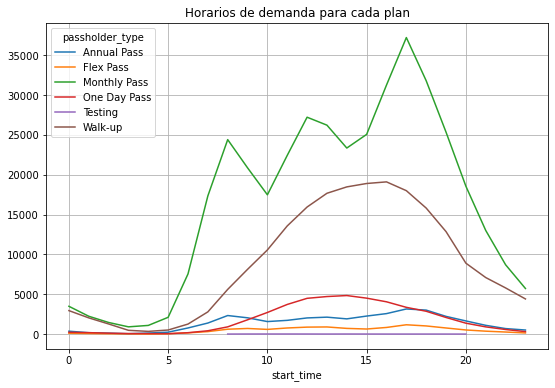

In [5]:
sat = data[['start_time','start_station','passholder_type']]
sat = sat.set_index('start_time')
sat.groupby([sat.index.hour,'passholder_type']).size().unstack().plot(figsize=(9,6), title="Horarios de demanda para cada plan", grid=True);

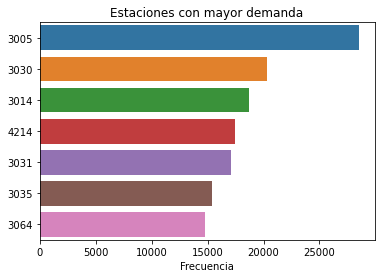

In [6]:
counts = sat['start_station'].value_counts()[:7]
ax = sns.barplot(x=counts, y=counts.index, order=counts.index, orient='h')
ax.set(title='Estaciones con mayor demanda', xlabel='Frecuencia');

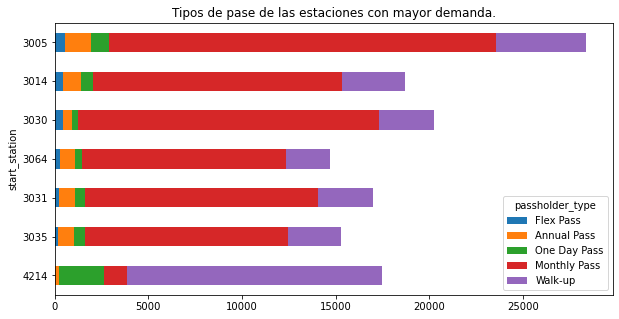

In [7]:
stat_pass = data.groupby(['start_station','passholder_type']).size()
top5 = list(counts.iloc[:7].index)
stat_pass05 = stat_pass.loc[stat_pass.index.get_level_values(0).isin(top5)].sort_values()
stat_pass05.unstack().plot(kind='barh', stacked=True, figsize=(10,5), title='Tipos de pase de las estaciones con mayor demanda.');

## Crecimiento de planes:
### Se tiene la intuición que la tendencia en uso de bicicletas compartidas va a la alta, por lo que se requiere realizar una correcta planificación de bicicletas que deben tener. Adicionalmente, se espera que los planes de consumo anual crezcan en mayor proporción.
Por lo que se observa en los gráficos, no existe una tendencia marcada en el uso de bicicletas o en el incremento de planes anuales y por el contrario, la tendencia va a la baja.

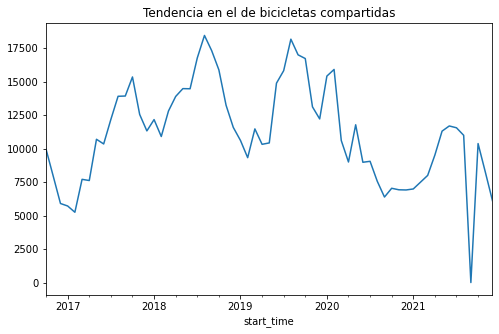

In [8]:
sat.resample('M').size().plot(figsize=(8,5), legend=False, title = 'Tendencia en el de bicicletas compartidas');

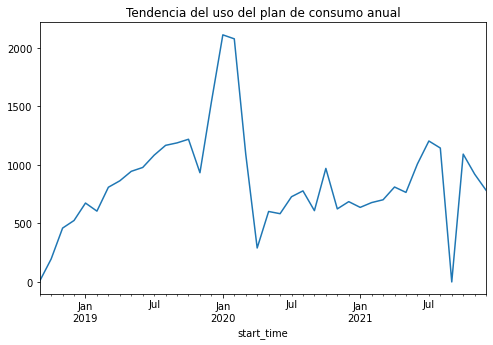

In [9]:
sat[sat['passholder_type']=='Annual Pass'].resample('M').size().plot(figsize=(8,5), legend=False, title='Tendencia del uso del plan de consumo anual');

# 2. Modelo analítico
### Construya un modelo analítico que incluya los puntos indispensables a considerar para un modelo (feature engineering, diseño de train-test split, cross-validation, métricas de desempeño, entre otros.
Lo primero será el tratamiento de datos nulos o faltantes.

In [10]:
df = data.copy()
print('Cantidad de registros:', df.shape)
df.isna().sum()

Cantidad de registros: (699983, 14)


trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5561
start_lon               5561
end_lat                18566
end_lon                18566
bike_id                    0
plan_duration            207
trip_route_category        0
passholder_type         2576
start_station              0
end_station                0
dtype: int64

* Las latitudes y longitudes dependen de la ubicación de la estación. Para tomar en cuenta esta característica se sebe suprimir alguna de la(s) otra(s). Además las mediciones son imprecisas en sus últimos decimales.
* Los registros que no contienen el tipo de plan del usuario no son de utilidad para el modelo, pues es la variable de interés.
* Plan duration está directamente relacionada con el tipo de pase y no es posible emplearla como variable de entrada en el modelo, porque no contaremos con esta información a futuro. Sin embargo, podría usarse como output alternativo.
* trip_route_category se relaciona con la estación de inicio y fin, sobre todo en los viajes redondos. Si queremos utilizar estas variables no podemos emplear modelos que asumen independencia. Lo segundo que podemos destacar es que esta variable es de tipo dicotómica, pues solo tenemos dos categorías: one way y round trip.
* passholder_type contiene 5 categorías, una de ellas nombrada testing. Para los 78 registros, plan duration tiene un valor de 999, por lo que podemos inferir que corresponde a las pruebas del servicio y prescindiremos de ella al analizar los datos.
* Todos los registros nulos de plan_duration corresponden a un pase mensual (passholder_type y viceversa.

In [11]:
df[(df['passholder_type']=='Monthly Pass') & (df['plan_duration'].isnull())].shape # (207, 14)
df[df['passholder_type'].isna() & (df['plan_duration']==30)].shape # (2576, 14)
# df[(df['passholder_type']=='Testing') | (df['plan_duration']== 999)].tail(3)

(2576, 14)

Por lo tanto, las modificaciones que realizaremos tomando en cuenta las observaciones son:
* Eliminar registros con categoría "Testing" en passholder_type y mapear NaNs.
* Ponderar latitudes y longitudes.
* Rellenar entradas nulas en plan_duration con el valor 30.
* Rellenar passholder_type nulo con Monthly Pass.
* Mapear la variable trip_route_category para convertirla en una variable numérica.

### Feature engineering
Se desea saber si es posible inferir si el tipo de pase es “Monthly Pass”, así que crearemos una columna numérica que lo represente. También agregaremos variables numéricas correspondientes al mes, día de la semana y hora, para medir su relación con la variable objetivo.

In [12]:
testing = df[df['passholder_type']=='Testing']
df = df.drop(testing.index) # Eliminar testing

df['start_lat'] = df.groupby('start_station')['start_lat'].transform('mean')
df['start_lon'] = df.groupby('start_station')['start_lon'].transform('mean')
df['end_lat'] = df.groupby('end_station')['end_lat'].transform('mean')
df['end_lon'] = df.groupby('end_station')['end_lon'].transform('mean')

df['passholder_type'] = df['passholder_type'].fillna('Monthly Pass')
df['plan_duration'] = df['plan_duration'].fillna(30)

trip_categ = {"One Way" : 0,
            "Round Trip" : 1}
df['trip_route_binary'] = df["trip_route_category"].map(trip_categ)
df['monthly_pass'] = df['passholder_type'].map(lambda x: 1 if x=='Monthly Pass' else 0)
df['month'] = df['start_time'].dt.month
df['day'] = df['start_time'].dt.dayofweek
df['start_hour'] = df['start_time'].dt.hour
df['end_hour'] = df['end_time'].dt.hour

print('Cantidad de registros:', df.shape)
df.isna().sum()

Cantidad de registros: (699905, 20)


trip_id                   0
duration                  0
start_time                0
end_time                  0
start_lat              4417
start_lon              4417
end_lat                6215
end_lon                6215
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type           0
start_station             0
end_station               0
trip_route_binary         0
monthly_pass              0
month                     0
day                       0
start_hour                0
end_hour                  0
dtype: int64

No se tienen valores de latitud o longitud para entradas correspondientes a las estaciones 4285 y 4286.

In [13]:
df[['start_lat', 'start_station']][df.isna().any(1)].head(2)

,start_lat,start_station
92,NaN,4285
93,NaN,4286


Como trip_id es un identificador único de viaje, no será útil como predictor y plan_duration es una variable de la que no dispondremos sin conocer los valores de la variable objetivo.

In [14]:
df = df.dropna()
# df = df.fillna(0)
df = df.drop(columns = ['trip_id', 'plan_duration'])
print('Cantidad de registros:', df.shape)

Cantidad de registros: (691213, 18)


### Identificación de outliers
El valor máximo para la duración de un viaje es de 1440 minutos, es decir 24 horas. Considerando que el viaje es en bicicleta y que el 75% de los datos no sobrepasan el valor de 26, podría deberse a un error. Inspeccionaremos con más detalle.

In [15]:
df.describe()

,duration,start_lat,start_lon,end_lat,end_lon,bike_id,start_station,end_station,trip_route_binary,monthly_pass,month,day,start_hour,end_hour
count,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000,691213.000000
mean,36.982629,34.044959,-118.253792,34.043722,-118.259713,10785.087076,3489.410882,3479.492550,0.168073,0.571909,6.777627,3.019026,14.126193,14.357266
std,125.269055,0.305009,2.168783,0.271327,1.923719,6446.627489,612.787120,609.934551,0.373931,0.494802,3.361381,1.982094,4.653979,4.765544
min,1.000000,33.710979,-118.491341,33.710979,-118.491341,4727.000000,3000.000000,3000.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,7.000000,34.037460,-118.280510,34.035679,-118.279762,6198.000000,3030.000000,3030.000000,0.000000,0.000000,4.000000,1.000000,11.000000,11.000000
50%,13.000000,34.046695,-118.256668,34.046520,-118.256668,6706.000000,3064.000000,3063.000000,0.000000,1.000000,7.000000,3.000000,15.000000,15.000000
75%,26.000000,34.051941,-118.246422,34.050911,-118.243530,15789.000000,4212.000000,4212.000000,0.000000,1.000000,10.000000,5.000000,18.000000,18.000000
max,1440.000000,53.648009,22.834424,53.007694,18.237240,536682.000000,4594.000000,4594.000000,1.000000,1.000000,12.000000,6.000000,23.000000,23.000000


Según nuestro violinplot no podemos considerar aislados ni erróneos estos valores.

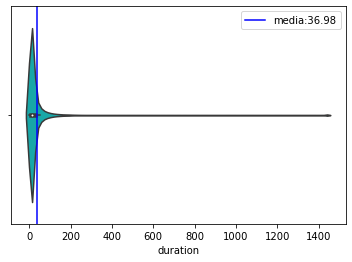

In [16]:
from scipy.stats import skew, kurtosis
sns.violinplot(x=df['duration'], color = 'c')
plt.axvline(df['duration'].mean(), c='b', label = 'media:'+ str(round(df['duration'].mean(),2)))
plt.legend();

Por tanto, no tenemos una distribución normal, en la cual los valores de curtosis y asimetría son cercanos a cero.
Para escalar nuestros datos no emplearemos StandardScaler, pues asume una distribución gaussiana.

Curtosis: 89.18579258906752
Asimetría: 8.994344192545105


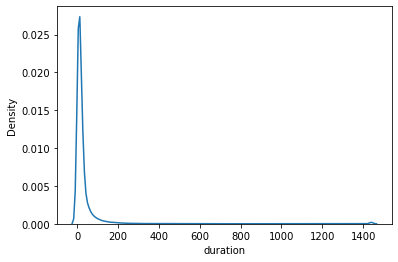

In [17]:
df_num = df.copy()._get_numeric_data()
print('Curtosis:', kurtosis( df_num['duration'] ))
print('Asimetría:', skew( df_num['duration'] ));
sns.kdeplot(df_num['duration']);

### ¿Qué variables impactan en la variable objetivo?
Aparentemente las longitudes de inicio y fin, así como la variable de tiempo mes, no son variables significativas.

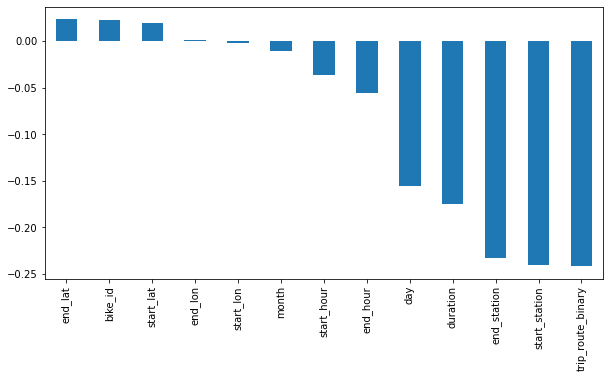

In [18]:
df_num = df.copy()._get_numeric_data()
df_num.corr()['monthly_pass'].sort_values(ascending=False)[1:].plot(kind='bar',figsize=(10,5));
# df_num = df_num.drop(columns=['start_lon','end_lon'])
df_num = df_num.drop(columns=['start_lon','end_lon','month'])

In [19]:
df_num.corr()['monthly_pass'].sort_values(ascending=False)[1:]

end_lat              0.023447
bike_id              0.022749
start_lat            0.019111
start_hour          -0.036370
end_hour            -0.055774
day                 -0.155328
duration            -0.174488
end_station         -0.232564
start_station       -0.240851
trip_route_binary   -0.241873
Name: monthly_pass, dtype: float64

Por último, es importante que cada clase de dato esté presente en una proporción balanceada. Tenemos una proporción del 57% al 43%, por lo que no será necesario hacer ningún tipo de remuestreo para emplear los datos de prueba.

In [20]:
df_num['monthly_pass'].value_counts()

1    395311
0    295902
Name: monthly_pass, dtype: int64

In [21]:
df_num.shape

(691213, 11)

### Entrenamiento y prueba
Dividiremos los datos en una proporción 80-20.Es decir, de los 699,905 registros 559,924 serán de entrenamiento y 139,981 de prueba.

In [22]:
X = df_num.drop('monthly_pass', axis=1)
y = df_num['monthly_pass']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=3)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # Escalamos los datos
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Construcción del modelo
Primero probamos distintos parámetros de configuración.

In [23]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cnf_matrix.ravel()
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred))
print("Especificidad:", tn / (tn + fp))

Precision: 0.7434332411237723
Exactitud: 0.7062853092019126
Sensibilidad: 0.7418705363926454
Especificidad: 0.6588719609927283


In [24]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dtc, X_train, y_train, scoring="accuracy")
print(f'Score del modelo: {scores["test_score"].mean():.3f} +/- {scores["test_score"].std():.3f}')

Score del modelo: 0.704 +/- 0.001


### Interprete el resultado en contexto del problema y determine qué variables impactan en la predicción
Entre las variables seleccionadas, las más significas para el modelo son la duración del viaje y la bicicleta empleada. El día, hora, las estaciones y su respectiva ubicación contribuyen cada una entre un 6 y 10% al modelo, mientras que la variable con menos contribución es trip_route, que hace referencia a si el viaje es de tipo redondo o no. Así, la decisión de adquirir el pase mensual no se fundamenta en una mayor o menor cantidad de viajes redondos.

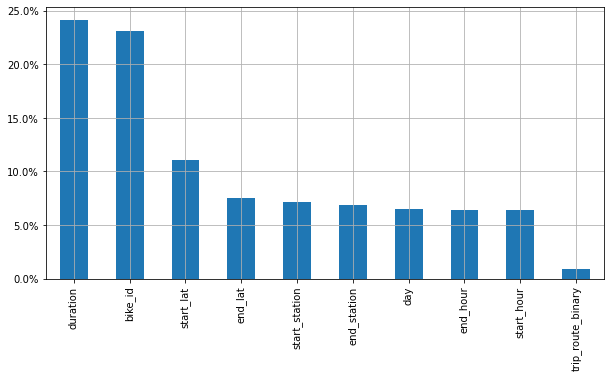

In [36]:
import matplotlib.ticker as mtick
feat_imp = pd.Series(dtc.tree_.compute_feature_importances(normalize=True), index=X.columns)*100
ax = feat_imp.nlargest(25).plot(kind='bar',figsize=(10,5), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

### ¿Cree que es un buen modelo?
* La desventaja de elegir este modelo es que las variables de entrada, desde un principio, no presentaban una fuerte correlación con la variable objetivo, por lo tanto no conseguimos un alto score de predicción.

Entre las ventajas tenemos:
* El modelo es explicativo y podemos conocer el impacto de cada variable añadida, algo que no sucede con el empleo de redes neuronales, KNN o de random forest, en estos ultimos, se debe a que obtenemos un promedio de todos los árboles. En las soluciones de negocio es vital entender el impacto de las variables para la implementación de estrategias comerciales.
* Entre las ventajas tenemos la fácil comprensión del modelo, incluso al aumentar las variables, algo que en otros modelos como una Máquina de soporte vectorial SVM no podrían ofrecer.
* Finalmente, un árbol de decisión requiere una capacidad computacional mucho menor que la implementación de KNN.

### ¿Qué variables adicionales añadiría para mejorar el modelo?
* Las características de la bicicleta serían un factor muy enriquecedor para este estudio, considerando que la cantidad de bicicletas disponibles es alrededor del 1% del total de viajes realizados, es decir, son utilizadas cientos de veces.
* Las características del cliente como género, edad, ocupación, entre otras, serían de gran utilidad para un análisis de segmentación de mercado.
* La tabla de información de las estaciones tampoco se encontraba disponible.

# 3. Evaluación del modelo

In [26]:
data_test = pd.read_csv('test_set.csv')
print('Cantidad de registros:', data_test.shape)
data_test.head()

Cantidad de registros: (569886, 12)


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
0,17059130,12,1/1/2017 0:24,1/1/2017 0:36,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028
1,17059129,17,1/1/2017 0:28,1/1/2017 0:45,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018
2,17059126,20,1/1/2017 0:39,1/1/2017 0:59,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055
3,17059125,12,1/1/2017 0:43,1/1/2017 0:55,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079
4,17061379,48,1/1/2017 0:56,1/1/2017 1:44,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063


Los datos al parecer requieren de todas las transformaciones anteriormente realizadas al set de entrenamiento.

In [27]:
data_test['start_time'] = pd.to_datetime(data_test['start_time'],infer_datetime_format=True)
data_test['end_time'] = pd.to_datetime(data_test['end_time'],infer_datetime_format=True)
alpha = data_test['bike_id'][pd.to_numeric(data_test['bike_id'], errors='coerce').isnull()]
data_test = data_test.replace(list(alpha.unique()), 1111) # testing en bike_id
data_test['bike_id'] = data_test['bike_id'].astype('int')
df_test = data_test.copy()
df_test['start_lat'] = df_test.groupby('start_station')['start_lat'].transform('mean')
df_test['start_lon'] = df_test.groupby('start_station')['start_lon'].transform('mean')
df_test['end_lat'] = df_test.groupby('end_station')['end_lat'].transform('mean')
df_test['end_lon'] = df_test.groupby('end_station')['end_lon'].transform('mean')

trip_categ = {"One Way" : 0,
            "Round Trip" : 1}
df_test['trip_route_binary'] = df_test["trip_route_category"].map(trip_categ)
df_test['day'] = df_test['start_time'].dt.dayofweek
df_test['start_hour'] = df_test['start_time'].dt.hour
df_test['end_hour'] = df_test['end_time'].dt.hour
df_test = df_test.fillna(0) # En las latitudes para las estaciones 4285 y 4286
df_test = df_test.drop(columns = ['trip_id','start_time','end_time', 'start_lon', 'end_lon'])
df_test_num = df_test.copy()._get_numeric_data()

X_test_submission = scaler.transform(df_test_num)
y_pred_submission = dtc.predict(X_test_submission)

In [39]:
# data_test[(data_test['start_station']==4285)|(data_test['start_station']==4286)] # 3642 rows × 12 columns

In [29]:
monthly = {0: None,
           1: 'Monthly Pass'}
predictions = pd.Series(y_pred_submission, name='passholder_type').map(monthly)
output = pd.concat([data_test['trip_id'], predictions], axis=1)
output
# output.to_csv('submission.csv', index=False)

,trip_id,passholder_type
0,17059130,Monthly Pass
1,17059129,None
2,17059126,Monthly Pass
3,17059125,None
4,17061379,None
...,...,...
569881,179408277,None
569882,179408276,Monthly Pass
569883,179409877,Monthly Pass
569884,179409876,None


Resultado obtenido en Kaggle
<img src="files/submission.png" width="700" height="400">
Comparto este resultado, aprovechando para señalar que el set de prueba presenta inconsistencias que afectan el rendimiento del modelo y carecen de sentido para los fines de la competencia. Las instrucciones en Kaggle eran un poco ambiguas y se proporcionaba poco contexto sobre el problema. Sin embargo, mis inferencias son lo más objetivas posibles.

# 4. Por último, se desea poner en producción el modelo. Describa qué pasos y consideraciones usted tomaría para lograrlo.
* Posterior al entrenamiento, debemos serializar el modelo y guardarlo.
* La forma más fácil de implementar un modelo de Machine Learning es  a través de un servicio API que acceda a los datos guardados y los actualice periódicamente.
* Se requiere de librerías como Flask y Django para definir la arquitectura de la API.
* También es necesario contar con un repositorio para realizar el versionado de modelos, pues estos pueden dejar de ser efectivos con el tiempo, para lo cual es necesario hacerles modificaciones.
* En producción se corren algoritmos de testing automatizado que son un filtro para subir a la red la nueva versión de la API.
* Todo esto coexiste en un ecosistema DevOps de integración y distribución contínua CI/CD, como por ejemplo, gitlab.

# Anexo
Modelos descartados

1. RandomForestClassifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, max_depth =7, n_estimators=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cnf_matrix.ravel()
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred))
print("Especificidad:", tn / (tn + fp))

Precision: 0.7210434960179701
Exactitud: 0.7419471510311553
Sensibilidad: 0.8942283340930963
Especificidad: 0.5390494508275548


LogisticRegression

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cnf_matrix.ravel()
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred))
print("Especificidad:", tn / (tn + fp))

Precision: 0.6819353518821604
Exactitud: 0.6860600536736037
Sensibilidad: 0.8441726181431394
Especificidad: 0.4753926878237249


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# Mejores parámetros para KNN
leaf_size = list(range(3,50))
n_neighbors = list(range(3,30))
p=[1,2]
#Convertir a dictionario
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knn_2 = KNeighborsClassifier()
#Usando GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


KeyboardInterrupt



3. KNeighborsClassifier

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cnf_matrix.ravel()
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred))
print("Especificidad:", tn / (tn + fp))

Precision: 0.7316237529470518
Exactitud: 0.7172732073233364
Sensibilidad: 0.7976877880767868
Especificidad: 0.6101297430446593
